<a href="https://colab.research.google.com/github/inConsciousness/random_forest/blob/main/Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
import pandas as pd

# Load dataset
data = fetch_california_housing()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Train a baseline model with default parameters
baseline_model = RandomForestRegressor(random_state=42)
baseline_model.fit(X_train, y_train)

# Predict using the baseline model
y_pred_baseline = baseline_model.predict(X_test)

# Evaluate the baseline model
mae_baseline = mean_absolute_error(y_test, y_pred_baseline)
mse_baseline = mean_squared_error(y_test, y_pred_baseline)
rmse_baseline = np.sqrt(mse_baseline)
r2_baseline = r2_score(y_test, y_pred_baseline)

# Print baseline performance
print(f"Baseline MAE: {mae_baseline:.4f}")
print(f"Baseline MSE: {mse_baseline:.4f}")
print(f"Baseline RMSE: {rmse_baseline:.4f}")
print(f"Baseline R² Score: {r2_baseline:.4f}")

Baseline MAE: 0.3275
Baseline MSE: 0.2554
Baseline RMSE: 0.5053
Baseline R² Score: 0.8051


In [29]:
!pip install optuna


In [30]:
import optuna

def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_depth = trial.suggest_int("max_depth", 2, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features='sqrt',
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return mean_squared_error(y_test, y_pred)

# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)
best_params = study.best_params

[I 2025-03-03 04:08:52,162] A new study created in memory with name: no-name-5a2bf12c-f74b-42ed-9976-0c5993f5d1ea
[I 2025-03-03 04:08:56,342] Trial 0 finished with value: 0.27385684406618266 and parameters: {'n_estimators': 115, 'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.27385684406618266.
[I 2025-03-03 04:09:03,772] Trial 1 finished with value: 0.39282380987104815 and parameters: {'n_estimators': 254, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.27385684406618266.
[I 2025-03-03 04:09:12,124] Trial 2 finished with value: 0.27873967916200393 and parameters: {'n_estimators': 210, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.27385684406618266.
[I 2025-03-03 04:09:17,095] Trial 3 finished with value: 0.2804400612759868 and parameters: {'n_estimators': 197, 'max_depth': 16, 'min_samples_split': 9, 'min_samples_leaf': 10}. Best is trial 0 with

In [31]:
import optuna.visualization as vis

# Optimization history plot
fig1 = vis.plot_optimization_history(study)
fig1.show()

# Hyperparameter importance plot
fig2 = vis.plot_param_importances(study)
fig2.show()

# Parallel coordinates plot (shows relationships between hyperparameters and objective value)
fig3 = vis.plot_parallel_coordinate(study)
fig3.show()

# Contour plot (shows interaction between two hyperparameters)
fig4 = vis.plot_contour(study)
fig4.show()

In [32]:
!pip install mlflow

In [33]:
import mlflow
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mlflow.set_experiment("random_forest_experiment")

# Train best model
rf_regressor = RandomForestRegressor(**best_params, random_state=42)
mlflow.start_run()
mlflow.log_params(best_params)

rf_regressor.fit(X_train, y_train)
y_pred_tuned = rf_regressor.predict(X_test)

# Evaluate the tuned model
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
mse_tuned = mean_squared_error(y_test, y_pred_tuned)
rmse_tuned = np.sqrt(mse_tuned)
r2_tuned = r2_score(y_test, y_pred_tuned)

mlflow.log_metrics({"MAE": mae_tuned, "MSE": mse_tuned, "RMSE": rmse_tuned, "R2": r2_tuned})
mlflow.end_run()

In [34]:
print("=== Model Performance Comparison ===")
print(f"Baseline RMSE: {rmse_baseline:.4f} | Tuned RMSE: {rmse_tuned:.4f}")
print(f"Baseline R² Score: {r2_baseline:.4f} | Tuned R² Score: {r2_tuned:.4f}")

=== Model Performance Comparison ===
Baseline RMSE: 0.5053 | Tuned RMSE: 0.5044
Baseline R² Score: 0.8051 | Tuned R² Score: 0.8059


<ipython-input-35-3577f4b8e4dd>:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




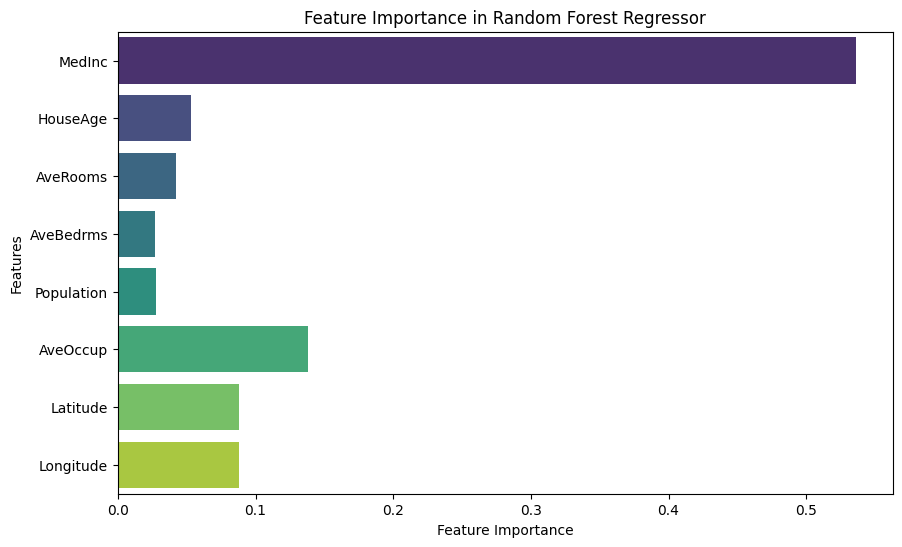

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_importance = rf_regressor.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10,6))
sns.barplot(x=feature_importance, y=feature_names, palette='viridis')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance in Random Forest Regressor')
plt.show()


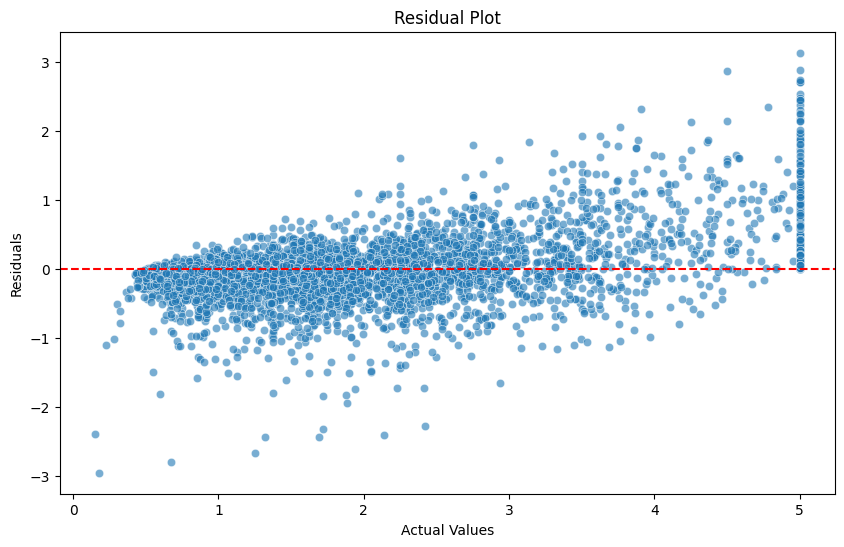

In [36]:
residuals = y_test - y_pred_tuned

plt.figure(figsize=(10,6))
sns.scatterplot(x=y_test, y=residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

Data Drift Score: 0.6712


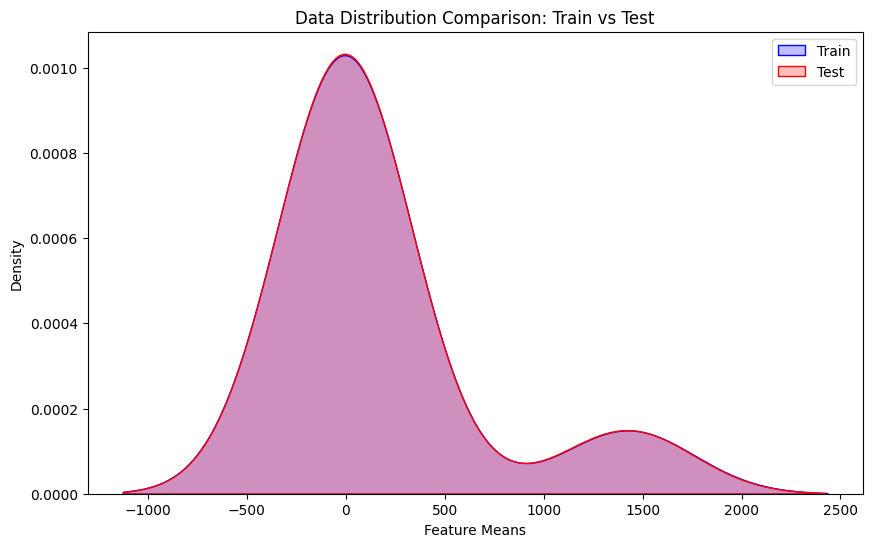

In [37]:
from scipy.stats import wasserstein_distance

# Compute data drift using Wasserstein Distance
drift_score = wasserstein_distance(X_train.mean(axis=0), X_test.mean(axis=0))
print(f"Data Drift Score: {drift_score:.4f}")

# Visualizing training vs testing data distributions
plt.figure(figsize=(10,6))
sns.kdeplot(X_train.mean(axis=0), label="Train", fill=True, color="blue")
sns.kdeplot(X_test.mean(axis=0), label="Test", fill=True, color="red")
plt.legend()
plt.xlabel("Feature Means")
plt.title("Data Distribution Comparison: Train vs Test")
plt.show()

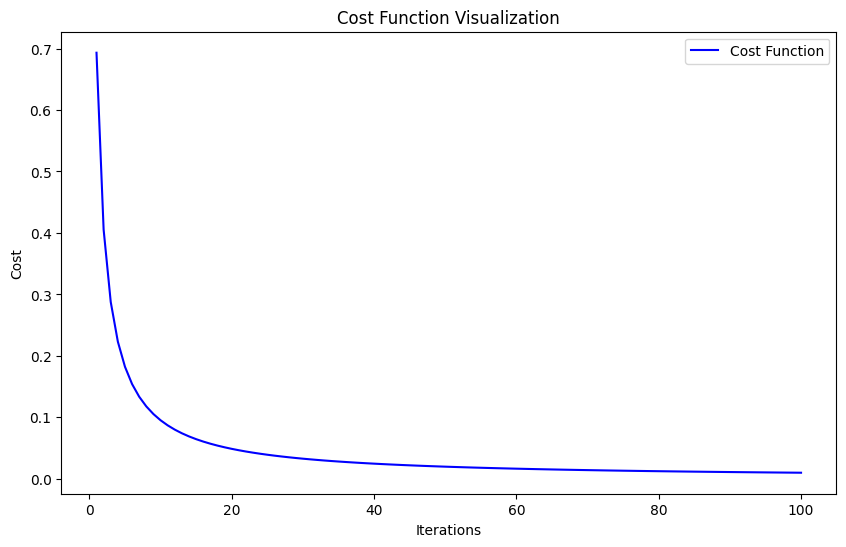

In [38]:
iterations = np.arange(1, 101)
cost_values = np.log(1 + 1/iterations)

plt.figure(figsize=(10,6))
plt.plot(iterations, cost_values, label='Cost Function', color='blue')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost Function Visualization')
plt.legend()
plt.show()

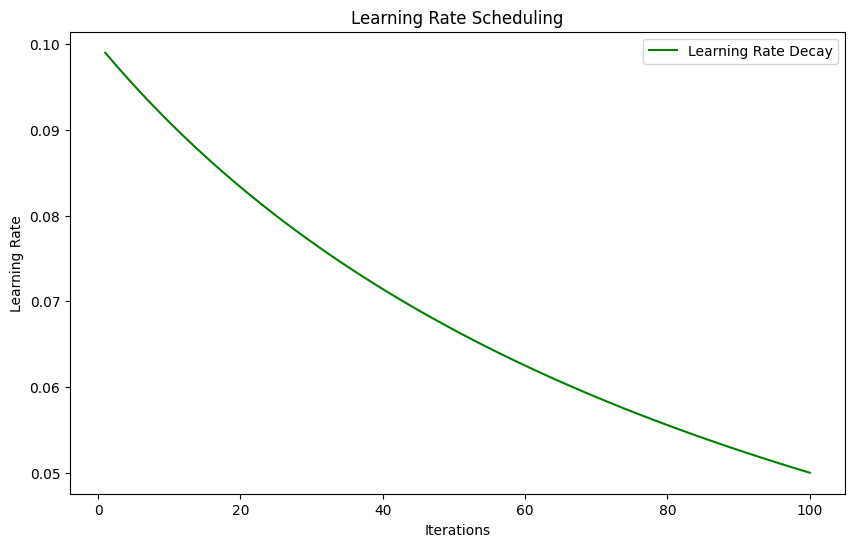

In [39]:
learning_rates = [0.1 / (1 + 0.01 * i) for i in iterations]

plt.figure(figsize=(10,6))
plt.plot(iterations, learning_rates, label='Learning Rate Decay', color='green')
plt.xlabel('Iterations')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Scheduling')
plt.legend()
plt.show()

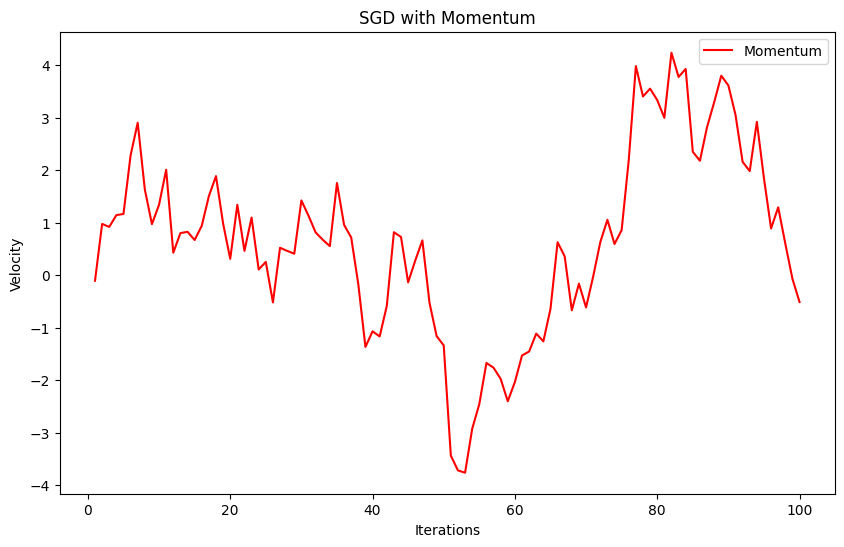

In [40]:
velocities = np.cumsum(0.9 * np.random.randn(100))

plt.figure(figsize=(10,6))
plt.plot(iterations, velocities, label='Momentum', color='red')
plt.xlabel('Iterations')
plt.ylabel('Velocity')
plt.title('SGD with Momentum')
plt.legend()
plt.show()

In [41]:
# Make predictions on test set
y_test_pred = rf_regressor.predict(X_test)

# Compute evaluation metrics
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

# Print results
print(f"Test MAE: {mae_test:.4f}")
print(f"Test MSE: {mse_test:.4f}")
print(f"Test RMSE: {rmse_test:.4f}")
print(f"Test R² Score: {r2_test:.4f}")

Test MAE: 0.3275
Test MSE: 0.2544
Test RMSE: 0.5044
Test R² Score: 0.8059


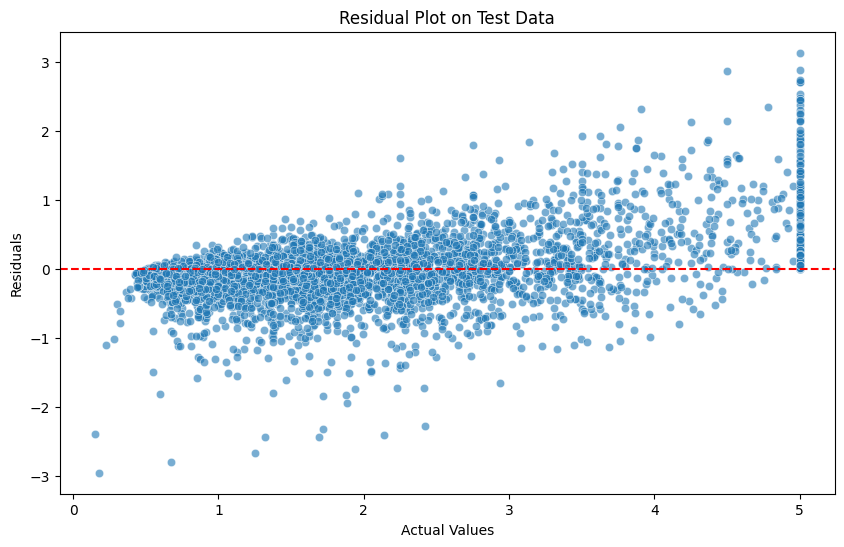

In [42]:
residuals_test = y_test - y_test_pred

plt.figure(figsize=(10,6))
sns.scatterplot(x=y_test, y=residuals_test, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residual Plot on Test Data')
plt.show()

In [43]:
# Pick a random sample from test set
sample = X_test.sample(1, random_state=42)

# Make prediction
sample_pred = rf_regressor.predict(sample)

# Show results
print("Sample Features:", sample.values)
print("Predicted Output:", sample_pred[0])

Sample Features: [[   2.8208       33.            4.05102041    1.15816327  739.
     1.88520408   34.17       -118.38      ]]
Predicted Output: 3.135539846497716


In [44]:
!pip install huggingface_hub joblib


In [45]:
!pip install huggingface_hub


In [46]:
from huggingface_hub import login

login()

In [47]:
import joblib
from huggingface_hub import HfApi

# Save model
model_path = "random_forest_model.pkl"
joblib.dump(rf_regressor, model_path)

# Define your Hugging Face repository (Replace 'your_hf_username'!)
repo_id = "Srivardhan369/random-forest-regressor"

# Upload model
api = HfApi()
api.upload_file(
    path_or_fileobj=model_path,
    path_in_repo="random_forest_model.pkl",
    repo_id=repo_id
)

print("✅ Model successfully uploaded to Hugging Face!")

random_forest_model.pkl:   0%|          | 0.00/135M [00:00<?, ?B/s]

✅ Model successfully uploaded to Hugging Face!
